# World War 2 Weather Linear Regression
This dataset contains weather data from 1942 to 1945.
The dataset can be found at https://www.kaggle.com/smid80/weatherww2/data.

The goal of this notebook is to visualize some of the weather data, and create a linear regression model to predict the max temperature given other columns. 

Notebook Created May 20, 2019

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [91]:
weatherData = pd.read_csv('Summary of Weather.csv')
print(weatherData.head())

     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
3        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
4        0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   

  RVG  WTE  
0 NaN  NaN  
1 NaN  NaN  
2 NaN  NaN  
3 NaN  NaN  
4 N

In [92]:
print(weatherData.columns)

Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')


From the columns shown above, to predict the Max Temperature, I'd like to use information about the precipitation, wind gust speed, min temp, mean temp, and snowfall. That should give me enough information about the overall weather to predict the max temperature.

In [93]:
newWeatherData = weatherData[['Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall']]
newWeatherData.rename(columns = {'WindGustSpd': 'WindSpeed', 'Snowfall':'SnowfallMM'}, inplace = True)
print(newWeatherData.head())

  Precip  WindSpeed    MaxTemp    MinTemp   MeanTemp SnowfallMM
0  1.016        NaN  25.555556  22.222222  23.888889          0
1      0        NaN  28.888889  21.666667  25.555556          0
2   2.54        NaN  26.111111  22.222222  24.444444          0
3   2.54        NaN  26.666667  22.222222  24.444444          0
4      0        NaN  26.666667  21.666667  24.444444          0


The temperatures recorded are in Celcius, let's go ahead and convert them into Farenheit to help understand the numbers more

In [94]:
newWeatherData['MaxTemp'] = newWeatherData['MaxTemp'].apply(lambda x: ((x * 9/5) + 32) )
newWeatherData['MinTemp'] = newWeatherData['MinTemp'].apply(lambda x: ((x * 9/5) + 32) )
newWeatherData['MeanTemp'] = newWeatherData['MeanTemp'].apply(lambda x: ((x * 9/5) + 32) )
print(newWeatherData.head())

  Precip  WindSpeed  MaxTemp  MinTemp  MeanTemp SnowfallMM
0  1.016        NaN     78.0     72.0      75.0          0
1      0        NaN     84.0     71.0      78.0          0
2   2.54        NaN     79.0     72.0      76.0          0
3   2.54        NaN     80.0     72.0      76.0          0
4      0        NaN     80.0     71.0      76.0          0


Now that we have a condened table of weather information, it's time to start investigating the stats of each column. Keep in mind that there are over 119,000 rows.

In [95]:
newWeatherData.info()
newWeatherData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 6 columns):
Precip        119040 non-null object
WindSpeed     532 non-null float64
MaxTemp       119040 non-null float64
MinTemp       119040 non-null float64
MeanTemp      119040 non-null float64
SnowfallMM    117877 non-null object
dtypes: float64(4), object(2)
memory usage: 5.4+ MB


,WindSpeed,MaxTemp,MinTemp,MeanTemp
count,532.000000,119040.00000,119040.000000,119040.000000
mean,37.774534,80.68120,64.021119,72.340936
std,10.297808,15.69207,15.002229,14.936368
min,18.520000,-28.00000,-37.000000,-32.000000
25%,29.632000,78.00000,59.000000,69.000000
50%,37.040000,85.00000,70.000000,78.000000
75%,43.059000,89.00000,74.000000,81.000000
max,75.932000,122.00000,94.000000,104.000000


Some interesting findings are that there are only 532 entries for wind speed. Trying to clean it wouldn't make sense because there's only 532 out of 119040 (0.004%) entries that aren't null. They make up such as tiny part of the data that cleaning it could skew the results. It wouldn't make sense to replace the null values with the mean of the column since the existing data makes up such a tiny percent of the overall data. Replacing every null value with 0 would also skew the data and throw off the model. So it's best to get rid of that column.

Side Note, there's some pretty cool info displayed. Throughout all the stations, the average temperature is 72F, but some station has seen a high of 122F and others have seen a low of -37F. 50% of the average temperature lies between 69F and 81F.

In [96]:
newWeatherData = newWeatherData.drop(columns = "WindSpeed")
newWeatherData.head()

,Precip,MaxTemp,MinTemp,MeanTemp,SnowfallMM
0,1.016,78.0,72.0,75.0,0
1,0,84.0,71.0,78.0,0
2,2.54,79.0,72.0,76.0,0
3,2.54,80.0,72.0,76.0,0
4,0,80.0,71.0,76.0,0


In [97]:
newWeatherData['SnowfallMM'].fillna(0, inplace = True)
newWeatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 5 columns):
Precip        119040 non-null object
MaxTemp       119040 non-null float64
MinTemp       119040 non-null float64
MeanTemp      119040 non-null float64
SnowfallMM    119040 non-null object
dtypes: float64(3), object(2)
memory usage: 4.5+ MB


We replaced the null values in Snowfall with 0. I'm getting a type error trying to input the mean value of the snowfall into the null values. Upon more further looking at the data further, there are a lot of string values within snowfall and precipitation, so until I get more experience in data cleaning, we'll have to leave that alone for now. 

In [103]:
x = newWeatherData[['MinTemp', 'MeanTemp']]
y = newWeatherData[['MaxTemp']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

regModel = LinearRegression()
regModel = regModel.fit(x_train, y_train)
print(regModel.coef_)
print(regModel.intercept_)

[[-0.88513157  1.87698179]]
[1.56384251]


We now have the equation used to fit the model.
maxTemp = (-0.8851x + 1.5638) + (1.8769 + 1.5638)

Looking at the slopes of the two columns, we see that the mean temp column has a significantly larger impact on predicting the max temperature than the min temp does.

In [107]:
maxTempPredicted = regModel.predict(x_test)
modelScore = regModel.score(x_test, y_test)
print("Accuracy:",modelScore)

Accuracy: 0.9843285113475596


With the information shown above, we see that the model can predict the max temperature of a day given the min temperature and the mean temperatrue with an accuracy of 98.4%

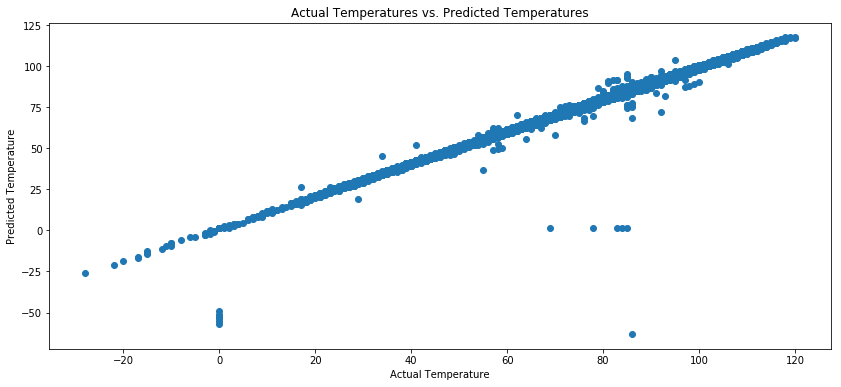

In [115]:
plt.figure(figsize = (14, 6))
plt.scatter(y_test, maxTempPredicted)
plt.title('Actual Temperatures vs. Predicted Temperatures')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.show()

In [128]:
def predictMaxTemperature(minTemperature, meanTemperature):
    predictedMaxTemp = regModel.predict([[minTemperature, meanTemperature]])
    print('Expected Max Temperature:', predictedMaxTemp)
    return predictedMaxTemp

In [129]:
print(predictMaxTemperature(67, 75))

Expected Max Temperature: [[83.03366164]]
[[83.03366164]]
